# Final Report - First Project Big Data

**Group Name:** HDFS - Hai Da Fare Stasera

**Group Members:** Alessio Ligios, Gianluca Visentin

## Indice

1. **Introduction**
    * Purpose of the project
    * Structure of the report
    
2. **Project specifications**
    * Datasets
        * Structure
        * Analysis
        * Data augmentation
    * Jobs
        * Job 1
        * Job 2
        * Job 3
        
3. **Planning and development**
    * *Map Reduce*
        * Job 1
        * Job 2
        * Job 3
    * *Hive*
        * Job 1
        * Job 2
        * Job 3
    * *Spark*
        * Job 1
        * Job 2
        * Job 3
        
4. **Results**
    * Job 1
    * Job 2
    * Job 3
    
5. **Tests**
    * Comparison metrics
    * Hardware and Software specifications
    * Charts
    
6. **Conclusions**
    * Job 1
    * Job 2
    * Job 3

# 1. Introduction


## Purpose of the project

The aim of the project is to design and implement 3 different jobs, each in MapReduce, Hive and Spark, comparing these three systems on each of them. The comparison is based on the analysis of job execution times both locally and on clusters, on the basis of variable input dimensions.

## Structure of the report

In the second chapter the datasets made available and the jobs to be carried out will be presented.
In the third chapter the implementations of the three jobs with the different technologies MapReduce, Hive and Spark will be shown in detail.
In the fourth chapter an example of the outputs generated for each of the three jobs will be shown.
In the fifth chapter the methodologies adopted to carry out the various comparisons between the technologies and the tests performed will be illustrated.
In the sixth and final chapter, the results obtained will be analyzed.

# 2. Project specifications

## Datasets

The dataset to be used, available at the course address, is that of daily stock prices for a selection of several thousand stock tickers from NYSE and NASDAQ. In the dataset there are historical stock prices for several thousand unique stock tickers, collected from 1970 to 2018.

### Structure

The datasets are organized as follows:

* `historical_stocks_prices.csv`: daily stock prices for a selection of several thousand stock tickers from NYSE and NASDAQ.

| FIELD NAME | TYPE   | DESCRIPTION              |
|------------|--------|--------------------------|
| Ticker     | Text   | The symbol for the stock |
| Open       | Number | The open price           |
| Close      | Number | The close price          |
| AdjClose   | Number | The adjusted close price |
| Low        | Number | The low price            |
| High       | Number | The high price           |
| Volume     | Number | The volume               |
| Date       | Date   | The date                 |

* `historical_stocks.csv`: this file contains information on the companies in the dataset. Attributes include industry, ticker, and sector.

| FIELD NAME | TYPE | DESCRIPTION                                                                         |
|------------|------|-------------------------------------------------------------------------------------|
| Ticker     | Text | The symbol for the stock (use this column to link with the stock prices data table) |
| Exchange   | Text | The name of the exchange (NYSE, NASDAQ)                                             |
| Name       | Text | The name of the company                                                             |
| Sector     | Text | The sector of the company                                                           |
| Industry   | Text | The industry of the company                                                         |

### Analysis

In this section the two datasets `historical_stocks.csv` and `historical_stocks_prices.csv` will be analyzed.

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
HISTORICAL_STOCKS_FILEPATH = 'historical_stocks.csv'
HISTORICAL_STOCK_PRICES_FILEPATH = '/historical_stock_prices.csv'

hs = pd.read_csv(HISTORICAL_STOCKS_FILEPATH)
hsp = pd.read_csv(HISTORICAL_STOCK_PRICES_FILEPATH)

* #### `historical_stocks.csv`

In [11]:
hs.shape

(6460, 5)

In [12]:
hs.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


This dataset contains 6460 lines and 5 fields

Now let's check if null and/or duplicate values are present in this dataset.

In [13]:
hs.isnull().any().any()

True

In [14]:
hs.isnull().any()

ticker      False
exchange    False
name        False
sector       True
industry     True
dtype: bool

We therefore note how fields are present, in particular `sector` and `industry` in the second dataset which have null values.
Now let's print some records containing null values.

In [15]:
hs[hs['sector'].isnull() | hs['industry'].isnull()].head()

,ticker,exchange,name,sector,industry
19,ABP,NASDAQ,ABPRO CORPORATION,NaN,NaN
42,SQZZ,NASDAQ,ACTIVE ALTS CONTRARIAN ETF,NaN,NaN
62,ACT,NASDAQ,ADVISORSHARES VICE ETF,NaN,NaN
100,ABDC,NASDAQ,ALCENTRA CAPITAL CORP.,NaN,NaN
124,SMCP,NASDAQ,ALPHAMARK ACTIVELY MANAGED SMALL CAP ETF,NaN,NaN


When implementing the jobs, it will therefore be necessary to take into account ignoring the records containing null `sector` and `industry` values.

In [16]:
len(hs['ticker']) != hs.shape[0]

False

Dunque non sono presenti valori duplicati per il file `historical_stocks.csv`.

* #### `historical_stock_prices.csv`

In [8]:
hsp.shape

(20973889, 8)

This dataset contains 20973889 lines and 8 fields

Now we print a subset of the lines in the `historical_stock_prices.csv` file.

In [9]:
hsp.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


A preliminary activity to the actual implementation of the work is that of cleaning the data in which there is a presence of any incorrect records (for example containing null values) that could be present in the data set. We check in particular that there are no null values in the `historical_stock_prices.csv` file.

In [10]:
hsp.isnull().any().any()

False

Therefore there are no null values. Another activity we can carry out is to check that there are no duplicate records, i.e. records that have the same `ticker` and the same date.

In [29]:
len(hsp.groupby(['ticker', 'date'])) != hsp.shape[0]

False

So there are no duplicate records.

* #### `historical_stocks.csv` & `historical_stock_prices.csv`

Now let's join the two datasets to carry out further analysis activities.

In [17]:
df = pd.merge(hs, hsp, on = 'ticker')

In [18]:
df.shape

(20973889, 12)

In [19]:
df.head()

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.00,7.95,7.95,7.90,8.50,642900,2014-04-01
1,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,7.94,8.16,8.16,7.90,8.29,228400,2014-04-02
2,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.29,8.39,8.39,8.05,8.40,105000,2014-04-03
3,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.50,8.69,8.69,8.32,8.70,113600,2014-04-04
4,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,9.00,8.94,8.94,8.55,9.00,60500,2014-04-07


We can check if a certain company is associated with more than one share (i.e. if there is a company name (`name`) associated with more than one` ticker`).

In [20]:
df.groupby('name')['ticker'].nunique().max()

12

In [21]:
df.groupby('name')['ticker'].nunique().idxmax()

'BARCLAYS PLC'

In [22]:
list(df[df['name'] == 'BARCLAYS PLC'].groupby(['name', 'ticker']).groups.keys())

[('BARCLAYS PLC', 'BCS'),
 ('BARCLAYS PLC', 'DFVL'),
 ('BARCLAYS PLC', 'DFVS'),
 ('BARCLAYS PLC', 'DLBL'),
 ('BARCLAYS PLC', 'DLBS'),
 ('BARCLAYS PLC', 'DTUL'),
 ('BARCLAYS PLC', 'DTUS'),
 ('BARCLAYS PLC', 'DTYL'),
 ('BARCLAYS PLC', 'DTYS'),
 ('BARCLAYS PLC', 'FLAT'),
 ('BARCLAYS PLC', 'STPP'),
 ('BARCLAYS PLC', 'TAPR')]

For example, we can see how * _BARCLAYS PLC_ * has 12 `tickers`.

Now let's check if there are companies (company names) associated with more than one sector

In [23]:
df.groupby('name')['sector'].nunique().max()

2

In [24]:
df.groupby('name')['sector'].nunique().idxmax()

'ENERGIZER HOLDINGS, INC.'

In [25]:
list(df[df['name'] == 'ENERGIZER HOLDINGS, INC.'].groupby(['name', 'sector']).groups.keys())

[('ENERGIZER HOLDINGS, INC.', 'CONSUMER NON-DURABLES'),
 ('ENERGIZER HOLDINGS, INC.', 'MISCELLANEOUS')]

We can see that *_ENERGIZER HOLDINGS, INC._* is associated with two sectors.

A further check that we can carry out is to check if there are companies that are listed on both the NYSE and NASDAQ

In [26]:
df.groupby('name')['exchange'].nunique().max()

2

In [27]:
df.groupby('name')['exchange'].nunique().idxmax()

'AMTRUST FINANCIAL SERVICES, INC.'

In [28]:
list(df[df['name'] == 'AMTRUST FINANCIAL SERVICES, INC.'].groupby(['name', 'exchange']).groups.keys())

[('AMTRUST FINANCIAL SERVICES, INC.', 'NASDAQ'),
 ('AMTRUST FINANCIAL SERVICES, INC.', 'NYSE')]

We note that for example *_AMTRUST FINANCIAL SERVICES, INC._* is listed on both exchanges.

### Data augmentation

As the goal of the project was to test the performance of the various systems according to different sizes of the dataset, a python script was generated that allowed to obtain files of different sizes to be used as datasets for the various tests.

The script does nothing but make a certain number of appendages (indicated as a parameter during the invocation) to the original file.

The following datasets have therefore been created:


|              DATASET NAME             | WEIGHT (GB) |                    DESCRIPTION                   |
|:-------------------------------------:|:-----------:|:------------------------------------------------:|
| historical_stock_prices_one_third.csv |     0.6     | The original file has been reduced by two thirds |
| historical_stock_prices_half.csv      |     1.03    | The original file has been shrunk by a third     |
| historical_stock_prices.csv           |     2.0     | The original file                                |
| historical_stock_prices_3x.csv        |     8.2     | The original file was chained 3 times.           |

## Jobs

This section describes in detail the three jobs that have been carried out.

### Job 1

The first job aims to generate statistics for each share between 2008 and 2018, indicating for each share: 
* (a) the symbol
* (b) the change in the price (rounded percentage difference between the initial and final closing prices of the time interval)
* (c) the minimum price
* (e) the maximum price
* (f) the average volume in the interval; all by ordering the list in descending order of variation of the quotation.

Companies born after 2008 or went bankrupt before 2018 are also of interest in this work.

### Job 2

The second job has the objective of generating, for each sector, the relative "trend" in the period 2008-2018; that is a list containing, for each year in the interval: 
* (a) the average annual volume of the sector's share
* (b) the average annual variation of the companies in the sector
* (c) the average daily price of the companies in the sector.

### Job 3

The second job aims to generate groups of companies whose actions have had the same trend in terms of annual variation in the last three years available, indicating the companies and the common trend (e.g. {Apple, Intel, Amazon}: 2016 : -1%, 2017: + 3%, 2018: + 5%).

# 3. Planning and development

## Map Reduce

Job MapReduce are developed in Python, the following approaches for the realization will be shown.

### Job 1

##### Mapper

During the mapping phase, we extrapolate the `ticker`, `close`, `low`, `high`, `volume` and `date` fields from each record.

We then check that the record is for a year that falls in the 2008-2018 interval, and then print the key the values associated with the key.
In particular, the key is made up of two fields: `ticker`, used as the "primary" key, and` date` used as the "secondary" key.

In this way values that will be received by the reducer will be aggregated for the `ticker` field only and sorted according to the` date` field (in this case we speak of *secondary sort*). This will allow in the reduction phase to avoid comparisons between dates (to find the most recent and the least recent date) for the purpose of calculating the percentage difference.

The value associated with the key, on the other hand, is made up of the `close`,` low`, `high` and` volume` fields.

```python
class mapper:
    
    map(key, specifics):
        ticker, _, close, _, low, high, volume, date = specifics
        year = getYear(date)
        if year in range from 2008 to 2018:
            key = ticker, date
            value = close, low, high, volume
            print(key, value)
```

##### Reducer

During the reduce phase we define a global variable `stats` containing a list of data structures that we will call below` item`, each of which contains the following fields:

- ticker
- Price variation
- average volume
- lowest price
- maximum price

In particular, each `item` is generated from a given pair (ticker, values) as input to the reduce phase.

Companies born after 2008 or which went bankrupt before 2018 were also included.

We now describe how the last 4 fields of this data structure are calculated.

In particular, to calculate the percentage difference we extract from the `valueList` list (see the pseudocode) the` close` field of the first and last element of the list, being the values associated with the tickers (i.e. the key) sorted by date. The percentage difference is then calculated.

As for the average volume, we extract the `volume` values associated with the current` ticker`, add these values ​​and divide the result by the number of `volume`.

Finally, in order to calculate the maximum and minimum price, the `low` and` high` fields are extracted from each element of the `valueList` list to then identify the minimum and maximum price.

The values thus calculated are then saved in the `item` data structure. At this point it is verified that the oldest date of the current ticker is 2008 as well as that the most recent date associated with the `ticker` processed is in the year 2018 and, if successful, the computed `item` data structure is added to the` stats` list.

Finally, once all tickers have been calculated, the `stats` list is sorted according to the` priceVariation` field of its elements (in descending order) and the first 10 of that ordered list are printed.

```python
class reducer:
    
    setup():
        stats = empty list

    reduce(ticker, records):
        totalVolume = 0
        countVolume = 0
        minLowPrice = infinity
        maxHighPrice = - infinity
        
        
        # get price variation
        closeStartingPrice = values.getFirstElement().getClose()
        closeFinalPrice = values.getLastElement.getClose()
        priceVariation = (closeFinalPrice - closeStartingPrice)/closeStartingPrice
        
        # compute remaining values 
        for each value in valueList:
            totalVolume += volume for current value
            countVolume += 1
            minLowPrice = min(minLowPrice, low price for current value)
            maxHighPrice = max(maxHighPrice, high price for current value)
        
        # get volume
        avgVolume = totalVolume/countVolume

        # add this item to stats list
        startingDate = values.getFirstElement().getYear()
        endingDate = values.getLastElement().getYear()
        if startingDate == 2008 and endingDate == 2018:
            obj = {ticker, priceVariation, minLowPrice, maxHighPrice, avgVolume}
            stats.append(obj)
    
    cleanup()
        sortedStats = sortByPriceVariation(stats, reverse=True)
        for i in range(10):
            print(sortedStats.getItem(i))
```

### Job 2

##### Mapper

Using the *Distributed Cache* (here de documentation https://hadoop.apache.org/docs/r3.0.0/api/org/apache/hadoop/filecache/DistributedCache.html) we can read the `historical_stocks.csv` file, to then define, starting from from the same file, a data structure (`tckrToSectorMap`) that associates to each` ticker` the corresponding sector (excluding the `tickers` without a corresponding sector).

The *Distributed Cache* in particular allows to make available to worker nodes, that is mapper and reducer, of files that can then be read for the purpose of carrying out the map and reduce activities respectively.

The `tckrToSectorMap` data structure thus created will be used during the mapping phase to be able to "join" with the records of the` historical_stock_prices.csv` file, associating the `ticker` sector in the record to each record.

During the mapping phase, we extrapolate the `ticker`,` close`, `volume` and` date` fields from each record, check that the record is for a year that falls in the 2008-2018 interval and then print the key value pair associated with the record in question.

In particular, the key is made up of three fields: `sector`, used as the "primary" key,` ticker` and `date`, where the latter two fields are used to perform the *secondary sort*, so that the values for the same sector are sorted (and aggregated) by `sector` and with the same` sector` are sorted by `ticker` and` data`.

Thanks to this ordering of the keys, it will then be possible in the reduction phase to be able to calculate the average annual variation associated with each sector without having to make a comparison between dates (in order to find the most recent and oldest date).

The value associated with the key, on the other hand, is made up of the `close` and` volume` fields.

```python
class mapper:
    
    setup():
        read the historical_stocks.csv file from the Distributed Cache
        tckrToSectorMap = map which associate a (non null) sector for each ticker in historical_stocks.csv
    
    map(key, specifics):
        ticker, _, close, _, _, _, volume, date = specifics
        year = getYear(date)
        if year in range from 2008 to 2018 and 
           ticker has a corresponding sector in tckrToSectorMap:
            sector = ticker corresponding sector
            key = sector, ticker, date
            value = close, volume
            print(key, value)
```

##### Reducer

During the reduce phase, for each sector we define a series of data structures (specifically key and value maps `yearToSectorTrend` and `yearToSectorDailyClosePrice`) aimed at calculating the average annual volume, the average daily price and the average annual variation by sector for each year.

We will now describe how these three values are calculated.

To calculate the average annual variation, the ordering of the values associated with each sector is used in order to extract the oldest and most recent closing prices of each `ticker` in each year. These values are then added for each year to obtain the annual "starting price" and the annual "final price" of the sector. Finally the average annual variation is calculated from these last two values.

To calculate the average daily price in a given year, the closing prices of the tickers relating to the same date are added first. An arithmetic average of the results thus obtained is carried out.

Finally, as regards the average annual volume, the records of the sector in question are scanned, adding together the volume values for the same year and dividing this sum by the number of `volume` relating to that specific year.

```python
class reducer:

    reduce(sector, records):
        yearToStartingCloseValueMap = empty map
        yearToEndingCloseValueMap = empty map
        yearToTotalVolumeMap = empty map
        yearToTotalCloseValue = empty nested map
        
        for record in specifics:
            day = get date field from the current record
            year = get year value from the day variable
            if the record corresponding ticker has changed from the previous record:
                yearToEndingCloseValueMap[previous year] += close field taken from the previous record
                yearToStartingCloseValueMap[year] += close field taken from the current record
            yearToTotalVolumeMap[year] += volume field taken from the current record
            countVolume[year] += 1
            yearToTotalCloseValue[year][date] += close
            
        priceVariation = empty map
  
        for each year from 2008 to 2018:
            difference = yearToEndingCloseValueMap[year] - yearToStartingCloseValueMap[year]
            priceVariation[year] = difference/yearToStartingCloseValueMap[year]
            count = number of date keys in yearToTotalCloseValue[year][date]
            averageClosePrice[year] = yearToTotalCloseValue[year][date]/count
            annualMeanVolume[year] = yearToTotalVolumeMap[year]/countVolume[year]
            print(sector, year, annualMeanVolume[year], priceVariation[year], averageClosePrice[year])
```

### Job 3

To carry out this job it was necessary to define a MapReduce application consisting of two jobs. The functions performed by each mapper and reducer of the MapReduce application created are described in words and by pseudocode.

##### First Mapper

Using the *Distributed Cache*, we can read the `historical_stocks.csv` file and then define, starting from the same file, a `tckrToCompanyNameMap` data structure which associates the name of the corresponding company to each `ticker`.

The `tckrToCompanyNameMap` data structure thus created will then be used to subsequently join with the mapper input records, associating the name of the company associated with the` ticker` in the record to each record.

Subsequently, during the mapping phase, after excluding `ticker` of which we do not know the `sector`, we extrapolate from each record the fields` ticker`, `close` and` date`, we verify that the record is relative to a year that falls in the 2016-2018 interval and then print the key value pair for the record in question.

In particular, the key is composed of three fields: `name`, used as the" primary "key,` ticker` and `date`, where these last two fields are used to perform the *secondary sort*, so that the values for the same company name is sorted (and aggregated) by `name` and, with the same` name`, is ordered by `ticker` and` data`.

Thanks to this ordering of the keys, it will then be possible during the reduction phase to be able to calculate the annual variation associated with each company name without having to make a comparison between dates (in order to find the most recent and oldest date).

The value associated with the key corresponds to the `close` field of the record.

```python
class mapper:
    
    setup():
        read the historical_stocks.csv file from the Distributed Cache
        tckrToCompanyNameMap = map which associate the respective company name for each ticker in historical_stocks.csv
    
    map(key, record):
        ticker, _, close, _, _, _, _, date = specifics
        year = getYear(date)
        if year in range from 2016 to 2018 and 
           ticker has a corresponding name in tckrToCompanyNameMap:
            companyName = ticker corresponding name
            key = name, ticker, date
            value = close
            print(key, value)
```

##### First Reducer

During the reduction phase, we define a series of data structures (specifically key value maps: `yearToCompanyTrend`) for each company name, aimed at calculating the annual variation for each year in the 2016-2018 interval of all companies.

In particular, to calculate the annual variation, the ordering of the values associated with each company name is used to extract the oldest and most recent closing prices of each `ticker` in each year. These values are then added for each year to obtain the annual "starting price" and the annual "final price" for that particular company. Finally, the annual variation is calculated from these last two values.

```python
class reducer:
    
    reduce(companyName, records):
        yearToStartingCloseValueMap = empty map
        yearToEndingCloseValueMap = empty map
        
        for record in specifics:
            day = get date field from the current record
            year = get year value from the day variable
            if the record corresponding ticker has changed from the previous record:
                yearToEndingCloseValueMap[previous year] += close field taken from the previous record
                yearToStartingCloseValueMap[year] += close field taken from the current record
            
        percentChangeMap = empty map
  
        for each year from 2016 to 2018:
            difference = yearToEndingCloseValueMap[year] - yearToStartingCloseValueMap[year]
            percentChangeMap[year] = difference/yearToStartingCloseValueMap[year]
        
        sortedPercentChangeMap = sorted(percentChangeMap)
            
        for each year in sortedPercentChangeMap:
            print(percentChangeMap[2016], percentChangeMap[2017], percentChangeMap[2018], companyName)
```

##### Second Mapper

This second mapper extracts the fields produced by the previous reducer from each record and outputs a key value pair where the key corresponds to triple the annual variation relating to 2016, 2017 and 2018, while the value corresponds to the company name.

In this way, during the reduction phase all the companies that have the same "trend" in terms of annual variation will be aggregated under the same key (ie triple of annual variation).

```python
class mapper:
    
    map(key, record):
        percentChange2016, percentChange2017, percentChange2018, companyName = record
        key = percentChange2016, percentChange2017, percentChange2018
        value = companyName
        print(key, value)
```

##### Second Reducer

During the reducer phase, we scan the records and then print all the companies that have the same triple in terms of annual variation.

```python
class reducer:

    
    reduce(percentTriplet, records):
        companyList = list of company which have the same "trend" (in other words the same annual variation triplet for 2016, 2017, 2018) 
        
        for each company in companyList:
            print(company, trend)
```

## Hive

As for Hive, the first step was to create the tables on which to query.

### Job 1

To improve the readability of the code of the first job and obtain the desired output, it was decided to add a modified version of table in Hive, containing the `date`, extracted from the dataset, in date format to allow a correct correlation of all dates from the 2008 to 2018.

A total of 6 views are defined:

* `parse_ticker_min_max_avg`, containing the minimum value of `low`, the maximum value of `high` and the average value for each `ticker`
* `parse_2008` and `close_ticker_2008`, containing the oldest date and the corresponding `close` value for each `ticker`
* `parse2018` and `close_ticker_2018`, containing the most recent date and the corresponding `close` value for each `ticker`
* `changes_odds`, which calculates the percentage change for each `ticker` from the previous views

Finally, a join is made between the `parse_ticker_min_max_avg` and c`hanges_odds` views to obtain the required result.

```SQL

CREATE VIEW IF NOT EXISTS parse_ticker_min_max_avg AS
SELECT ticker, min(low) AS min_price, max(high) AS max_price, avg(volume) AS avg_volume
FROM historical_stock_prices_date
WHERE data>='2008-01-01' AND data<='2018-12-31' 
GROUP BY ticker;
 
 
CREATE VIEW IF NOT EXISTS parse_2008 AS
SELECT ticker, min(data) AS min_data
FROM historical_stock_prices_date
WHERE data>='2008-01-01' AND data<='2018-12-31'
GROUP BY ticker;
 
 
CREATE VIEW IF NOT EXISTS parse2018 AS
SELECT ticker, max(data) AS max_data
FROM historical_stock_prices_date
WHERE data>='2008-01-01' AND data<='2018-12-31'
GROUP BY ticker;
 
 
CREATE VIEW IF NOT EXISTS close_ticker_2008 AS
SELECT hspd.ticker, hspd.data, hspd.close
FROM parse_2008 AS min, historical_stock_prices_date AS hspd
WHERE hspd.ticker=min.ticker AND hspd.data=min.min_data;
 
 
CREATE VIEW IF NOT EXISTS close_ticker_2018 AS
SELECT hspd.ticker, hspd.data, hspd.close
FROM parse2018 AS max, historical_stock_prices_date AS hspd
WHERE hspd.ticker=max.ticker AND hspd.data=max.max_data;
 
 
CREATE VIEW IF NOT EXISTS changes_odds AS
SELECT ci.ticker, FLOOR(((cf.close-ci.close)/ci.close)*100) AS var_perc
FROM close_ticker_2018 AS cf join close_ticker_2008  AS ci on cf.ticker=ci.ticker;
 
 
CREATE TABLE IF NOT EXISTS result_job1 AS
SELECT a.ticker, b.var_perc, a.min_price, a.max_price, a.avg_volume
FROM parse_ticker_min_max_avg AS a join changes_odds AS b on a.ticker=b.ticker
ORDER BY b.var_perc DESC limit 10;
```

### Job 2

Initially it was decided to join between the two tables that contain the file, `historical_stock_prices.csv` and `historical_stocks.csv` by placing the table that contains the daily records to the right of the join operator to improve the efficiency of the operation. During the join operation, the tickers that are not associated with any sector are filtered.

8 views are then defined:

* `volume_sector`, through which the sum of all volumes for a given sector is calculated, counting the number of tickers taken into consideration
* `average_sector`, in which the average is calculated as the ratio between the sum of the volumes and the number of tickers, rounding up to the unit
* `sector_data_min_max`, which contains the oldest and most recent dates for each ticker and each year
* `sector_data_close_2008` and `sector_data_close_2018`, which contain the overall closing price associated with the oldest and most recent date for each sector in each year
* `sector_data_close`, which contains the rounded percentage change for each sector in each year
* `sector_data_sum_close`, which contains the sum of the closing prices of the same day for all tickers of the same sector
* `sector_data_avg_close`, containing the average daily price for each sector in each year

Finally, the join is made between the tables `sector_data_avg_close`, `sector_data_close` and `average_sector` to obtain the required output.

```SQL

CREATE TABLE IF NOT EXISTS main_table AS 
SELECT hs.sector, hsp.ticker, hsp.data, hsp.close, hsp.volume 
FROM historical_stock AS hs JOIN historical_stock_prices_string AS hsp ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2008 AND YEAR(hsp.data)<=2018 AND hs.sector!='N/A';


CREATE VIEW IF NOT EXISTS volume_sector AS 
SELECT sector, YEAR(data) AS anno, SUM(volume) AS somma_volume, count(ticker) as conteggio
FROM main_table 
GROUP BY sector, YEAR(data);


CREATE VIEW IF NOT EXISTS average_sector AS
SELECT sector, anno,ROUND((somma_volume/conteggio)) as avg_volume
FROM volume_sector;


CREATE VIEW IF NOT EXISTS sector_data_min_max AS 
SELECT sector, ticker, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM main_table 
GROUP BY sector, ticker, YEAR(data);


CREATE VIEW IF NOT EXISTS sector_data_close_2008 AS 
SELECT b.sector, YEAR(b.min_data) AS anno, SUM(a.close) AS min_close 
FROM main_table AS a, sector_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.min_data AND b.ticker=a.ticker 
GROUP BY b.sector, YEAR(b.min_data);


CREATE VIEW IF NOT EXISTS sector_data_close_2018 AS 
SELECT b.sector, YEAR(b.max_data) AS anno, SUM(a.close) AS max_close 
FROM main_table AS a, sector_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.max_data AND b.ticker=a.ticker 
GROUP BY b.sector, YEAR(b.max_data);

CREATE TABLE IF NOT EXISTS sector_data_close AS 
SELECT mi.sector, mi.anno, ROUND(AVG(((ma.max_close-mi.min_close)/mi.min_close)*100),2) AS perc_var_anno 
FROM sector_data_close_2008 AS mi, sector_data_close_2018 AS ma 
WHERE mi.sector=ma.sector AND mi.anno=ma.anno
GROUP BY mi.sector, mi.anno; 


CREATE VIEW IF NOT EXISTS sector_data_sum_close AS 
SELECT sector, data, SUM(close) AS somma
FROM main_table 
GROUP BY sector, data;


CREATE VIEW IF NOT EXISTS sector_data_avg_close AS 
SELECT sector, YEAR(data) AS anno,AVG(somma) AS media 
FROM sector_data_sum_close 
GROUP BY sector, YEAR(data);


CREATE TABLE IF NOT EXISTS result_table_job2 AS
SELECT a.sector, a.anno, c.avg_volume, b.perc_var_anno, a.media 
FROM sector_data_avg_close AS a, sector_data_close AS b, average_sector AS c 
WHERE a.sector=b.sector AND b.sector=c.sector AND a.anno=b.anno AND c.anno=b.anno
ORDER BY sector, anno;
```

### Job 3

Initially it was decided to join between the two tables that contain the file, `historical_stock_prices.csv` and `historical_stocks.csv` by placing the table that contains the daily records to the right of the join operator to improve the efficiency of the operation. During the join operation, the tickers that are not associated with any sector are also filtered based on the 2016-2018 three-year period.

We then define 1 view and 4 tables:

* `name_data_min_max`, includes for each ticker and every year the oldest and most recent date
* `name_data_close_min`, with which the closing prices for the oldest tickers are added
* `name_data_close_max`, with which the closing prices for the less dated tickers are added
* `name_anno_close`, which contains the percentage change for each sector in each year
* `name_anno_close_joined`, is placed on the same output line, through the concatenation function, the set of names for which the trend is similar based on the percentage variation

Finally, a last table is created to obtain the desired output, in which some conditions are specified according to which companies with different names and the same quotation are grouped.

```SQL

CREATE TABLE IF NOT EXISTS table_job3 AS 
SELECT t1.name, t1.sector, t2.data, t2.close, t2.ticker
FROM historical_stock AS t1 JOIN historical_stock_prices_string AS t2 on t2.ticker=t1.ticker
WHERE YEAR(data)>=2016 AND YEAR(data)<=2018 AND t1.sector!='N/A';


CREATE VIEW IF NOT EXISTS name_data_min_max AS 
SELECT name, ticker, sector, YEAR(data) AS anno, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM table_job3 
GROUP BY name, ticker, sector, YEAR(data);


CREATE VIEW IF NOT EXISTS name_data_close_min AS 
SELECT b.name, a.ticker, YEAR(b.min_data) AS anno, SUM(a.close) AS min_close 
FROM table_job3 AS a, name_data_min_max AS b 
WHERE a.ticker=b.ticker AND a.data=b.min_data 
GROUP BY b.name,a.ticker, YEAR(b.min_data);


CREATE VIEW IF NOT EXISTS name_data_close_max AS 
SELECT b.name, a.ticker, YEAR(b.max_data) AS anno, SUM(a.close) AS max_close 
FROM table_job3 AS a, name_data_min_max AS b 
WHERE a.data=b.max_data AND a.ticker=b.ticker
GROUP BY b.name, a.ticker, YEAR(b.max_data); 


CREATE TABLE IF NOT EXISTS name_anno_close AS 
SELECT ndc_mi.name, ndc_mi.ticker,ndc_mi.anno, ROUND((ndc_ma.max_close-ndc_mi.min_close)/ndc_mi.min_close *100, 0) AS perc_var_anno
FROM name_data_close_min AS ndc_mi, name_data_close_max AS ndc_ma
WHERE ndc_mi.name=ndc_ma.name AND ndc_mi.anno=ndc_ma.anno AND ndc_mi.ticker=ndc_ma.ticker
ORDER BY  ticker, anno;


CREATE TABLE name_anno_close_joined AS 
SELECT name, concat_ws(',', collect_list(cast (perc_var_anno as STRING)))AS quotazione, anno
FROM name_anno_close
GROUP BY name, anno;


CREATE TABLE result_table_job3 AS
SELECT collect_set(v1.name), v1.quotazione as var16, v2.quotazione as var17, v3.quotazione as var18
FROM name_anno_close_joined v1, name_anno_close_joined v2, name_anno_close_joined v3
WHERE v1.name = v2.name AND v1.anno != v2.anno != v3.anno AND v1.name = v3.name AND v1.anno = '2016' and v2.anno = '2017' and v3.anno = '2018'
GROUP BY v1.quotazione, v2.quotazione, v3.quotazione
HAVING count(*)>1;
```

## Spark

### Job 1

The following `RDD` are specified for the execution of the job:

* `low_min_tckr`, contains for each ticker the minimum close price in the interval

* `high_max_tckr`, contains for each ticker the maximum close price in the interval

* `mean_volume_tckr`, contains the average daily volume for each ticker

* `min_close_total`, contains for each ticker the closing price for the oldest date

* `max_close_total`, contains for each ticker the closing price for the most recent date

On these last two `RDD` the join is made to obtain the `join_price_variation`, on which the percentage variation for each ticker will be calculated successively by means of the formula present in the RDD `price_variation`.

Once all the data are obtained, the join is made between the RDD ticker_`min_close_total`, `max_close_total`, `mean_volume_tckr`, `price_variation` to obtain the result. The RDD of the result will then be sorted on the basis of the percentage change, in descending order, as required in the specification and the first 10 records produced will be taken.

The implementation pseduocode follows:

```python
reads all lines in the historical_stock_prices.csv file with a date between 2008 and 2018
 

low_min_tckr = input.map(line -> (ticker, low)) 
    .reduceByKey(min(low1, low2)) 

high_max_tckr = input.map(line -> (ticker, high))  
    .reduceByKey(max(high1, high2)) 

mean_volume_tckr = input.map(line -> (ticker, (volume, 1)))  
    .reduceByKey((volume1 + volume2, count+1)) 
    .map(line -> (ticker, tot_volume/count)) 

min_close_total = input.map(line -> (ticker, (close, date)))  
    .reduceByKey(min((date1, close1), (date2, close2))) 

max_close_total = input.map(line -> (ticker, (close, date))) 
    .reduceByKey(max((date1, close1), (date2, close2))) 
   

join_price_variation = min_close_total.join(max_close_total) 

price_variation = join_price_variation 
    .map(line -> (ticker, (max_close - min_close)/min_close)) 

    
stats = high_max_tckr.join(low_min_tckr) 
    .join (price_variation) 
    .join (mean_volume_tckr) 
    .sortBy(price_variation decreasing)
    .take(10)

```

### Job 2

The following `RDD` are specified for the execution of the job:

* `mean_volume`, contains for each sector, for each year of the interval, the average volume

* `mean_sum_close`, contains for each sector, for each year of the interval, the average daily price

* `min_close_total`, contains for each sector, for each year of the interval, the close quotation with an older date

* `max_close_total`, contains for each sector, for each year of the interval, the close quotation with the most recent date

On these last two `RDD` the join is made to obtain the join_price_variation, on which the average percentage variation for each year of the interval for each sector will be calculated subsequently, using the formula present in the `RDD` `price_variation`.

Finally, the join is made between `mean_sum_close`, `mean_volume` and `price_variation` to obtain the output required by the job, sorted by sector.

The implementation pseduocode follows:

```python
hsp = RDD which contains the dataset historical_stock_prices.csv with the records relating to the years in the range 2008-2018

hs = RDD containing the historical_stocks.csv dataset, filtering the records in which the sector field assumes null or 'N/A' values
 

mean_volume  = join_hsp_hs.map(line -> ((sector, year), volume) 
    .map(line -> ((sector, year), volume, 1) 
    .reduceByKey(volume1 + volume2, count_volume + 1) 
    .map(line -> (sector (sum_volume/count_volume) 

mean_sum_close = join_hsp_hs 
    .map(line -> ((sector, date), close))  
    .reduceByKey(close1 + close2)  
    .map(line -> ((sector, year), (sum_close, 1))) 
    .reduceByKey(line -> (sum_close1 + sum_close2, count_close + 1)) 
    .map(line -> (sector, (sum_close/count_close)) 

min_close_total = join_hsp_hs
    .map(line -> ((ticker, sector, year), (close, date))) 
    .reduceByKey(min((date1, close1), (date2, close2))) 
    .map(line -> ((sector, year), min_close))  
    .reduceByKey(min_close1 + min_close2) 

max_close_total = join_hsp_hs
    .map(line -> ((ticker, sector, year), (close, date)))  
    .reduceByKey(max((date1, close1), (date2, close2))) 
    .map(line -> ((sector, year), max_close))  
    .reduceByKey(max_close1 + max_close2) 

         
join_price_variation = min_close_total.join(max_close_total) 

price_variation = join_price_variation
    .map(line -> (ticker, (max_close_total - min_close_total)/min_close_total * 100)) 

 
stats = price_variation
    .join(mean_sum_close) 
    .join(mean_volume) 
    .sortBy(sector) 
```

### Job 3

The following `RDD` are specified for the execution of the job:

* `min_close_total`, contains for each company, for each year of the interval, the portion relating to the oldest date

* `max_close_total`, contains for each company, for each year of the interval, the quota for the most recent date

On these `RDD` the join is carried out to obtain the `join_price_variation`, on which the percentage or trend variation will be calculated subsequently, for each year of the interval, for each company.

`price_variation` will have the name as key and the year and its percentage change as values.

A `RDD` called `trend` will then be defined, which will go through the percentage change by extracting and grouping the calculated trends for each company. Subsequently, in `trend_clean`, every record in the `RDD` previously defined, will be cleaned up by all companies that do not have trend values even for just one of the 3 years of the interval.

In the next phase, a function called "ordering_triplet" is applied which takes care of sorting increasingly, the years present `trend_clean` to obtain a uniform result.

Finally, all companies that will have the same trend for the three-year period will be taken and aggregated as output, from `RDD` `trend_clean_order`, returning the desired result in the form (company names, trend equal to three years).

The implementation pseduocode follows:

```python
hsp = RDD containing the dataset historical_stock_prices.csv, with the records relating only to the years in the interval 2016-2018

hs = RDD containing the historical_stocks.csv dataset, filtering the records in which the sector field takes the value "N/A"


min_close_total = join_hsp_hs
    .map(line -> ((ticker, year, close), (ticker, name))) 
    .reduceByKey(min((date1, close1), (date2, close2)))  
    .map(line -> ((name, year), min_close))         
    .reduceByKey(min_close1 + min_close2) 

max_close_total = join_hsp_hs
    .map(line -> ((ticker, year, close), (ticker, name))) 
    .reduceByKey(max((date1, close1), (date2, close2)))  
    .map(line -> ((name, year), max_close)) 
    .reduceByKey(max_close1 + max_close2) 

    
join_price_variation = min_close_total.join(max_close_total) 

price_variation = join_price_variation
    .map(line -> (name, (max_close_total – min_close_total)/min_close_total * 100)) 

trend = price_variation
    .map(line -> ((name), ([(year, price_variation)]))) 
    .reduceByKey(([(year1, price_variation1).concat(year2, price_variation2)])) 

trend_clean = trend.filter(linea -> filtering the lines that contain non-zero percentage increase values in at least one of the years 2016 2017 and 2018) 

trend_clean_order = trend_clean.map(line -> sort(line)) 

 
stats = trend_clean_order. 
    .map(line -> ([year1, trend1, year2, trend2, year3, trend3]),((name))) 
    .reduceByKey(name1 + name2).filter(len(name))>=2 
    .map(line -> (name, year1: trend1, year2: trend2, year3: trend3) 
    .sortBy(year, trend increasing) 
```

# 4. Results

In this part the results obtained after running the three jobs will be presented.

### Job 1

The first 10 lines of the output produced for job 1 are reported:

```
Ticker	   Percentage Variation    Lowest Price          Maximum Price         Average Volume
 
EAF	      267757.134589%	      0.00200000009499	  24.3640003204	     1245139.03846
ORGS	     217415.926128%	      0.00313999992795	  19.9200000763	     8570.9623431
PUB	      179900.004023%	      0.00899999961257	  138.0	             34449.4007092
RMP	      121081.601901%	      0.0299999993294	   79.8187332153	     120487.047671
CTZ	      120300.00231%	       0.00499999988824	  26.8400001526	     52050.2730807
CCD	      111250.004778%	      0.0149999996647 	  25.9799995422	     105416.892662
SAB	      110428.769954%	      1.3654999733	      319600.0	          1695378.01632
KE	       99400.0003166%	      0.0149999996647	   22.4500007629	     73249.8461538
LN	       96699.9992053%	      0.0149999996647	   51.4799995422	     394344.929641
GHG	      64850.0003073%	      0.00499999988824	  25.1000003815	     607659.292629
```

### Job 2

The first 10 lines of the output produced for job 2 are reported:

```
Sector			  Year    Average Annual Volume     Average Annual Variation	  Average Daily Price

BASIC INDUSTRIES	2008	2315405                   -0.050131389643	           7124.09400267
BASIC INDUSTRIES	2009	2440724                    0.0348287578952	          4727.91920472
BASIC INDUSTRIES	2010	2017339	                0.217900355607	           6126.05228338
BASIC INDUSTRIES	2011	1853541                   -0.586007636167	           8535.55187455
BASIC INDUSTRIES	2012	1552641	               -0.687885248968               8694.81899382
BASIC INDUSTRIES	2013	1514508	                0.103226361955	           28486.4249861
BASIC INDUSTRIES	2014	1460847	               -0.719021325857	           24380.2074047
BASIC INDUSTRIES	2015	1610008	               -0.481011719633	           9538.71135927
BASIC INDUSTRIES	2016	1937797	                0.138293577492	           7721.85529589
BASIC INDUSTRIES	2017	1557227	                0.152790107615	           9101.40840867
```

### Job 3

```
Companies                                                                    2016        2017        2018

STURM, RUGER & COMPANY, INC. - LINCOLN EDUCATIONAL SERVICES CORPORATION 	 -14%	     4%	     8%
PENNYMAC FINANCIAL SERVICES, INC. - LEAR CORPORATION 	                     10%	     33%       -8%
HERSHEY COMPANY (THE) - SPECTRUM BRANDS HOLDINGS, INC.                        18%	     9%	    -11%
GENTEX CORPORATION - CALERES, INC. 	                                       25%	     3%	     11%
TERRENO REALTY CORPORATION - DUNKIN&#39; BRANDS GROUP, INC. 	              28%	     23%        9%
SIGNATURE BANK - COMPASS MINERALS INTERNATIONAL, INC.	                     3%	     -8%	    -15%
DENNY&#39;S CORPORATION - WINMARK CORPORATION 	                            35%	     4%	     14%
MIDDLESEX WATER COMPANY - INTERNATIONAL BANCSHARES CORPORATION 	           64%	    -3%	     18%
```

# 5. Tests

This chapter explains the metrics used to compare various systems. The specifications of the systems used for local and cluster executions and the results of the tests carried out will be illustrated.
The various tests will be analyzed with a subdivision that allows to evaluate the performance of a system on the various environments but also to evaluate how the various systems behave on the same environment.

## Comparison metrics

The metrics used to make the comparison between the systems are those relating to:

* Execution time
* Average execution time
* Execution environment (Local / Cluster)
* Dataset size (as illustrated in the second chapter)

## Hardware and Software specifications

The environments on which the various tests were carried out are two: one local and one in the cloud (AWS).

### Local environment

#### Hardware specifications

* CPU: Intel Core i5 dual-core 2,9 GHz
* RAM: 16 GB 2133 MHz LPDDR3
* Storage memory: 256 GB (SSD)

#### Software specifications

* macOS Catalina 10.15.4 
* Java 1.8.0_241  
* Python 3.7 
* Hadoop 3.2.1 
* Apache Hive 3.1.2 
* Spark 3.0.0 con Hadoop 3.2.X 

### Cluster environment

The cluster was created using the "AWS Educate" service.

#### Hardware specifications

* CPU: 4 vCore, emr 6.0.0 x5-large
* RAM: 16 GB
* Storage memory: EBS 64 Gb
* Architecture: 1 Master node, 3 Slave nodes

#### Software specifications

* Java 1.8.0_242 
* Hadoop 3.2.1 
* Python 3.7.4 
* Hive 3.1.2 
* Spark 2.4.4 

## Charts

The comparisons relating to the 3 jobs will be shown, both locally and in clusters, to get an overview of the various jobs run on the different machines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
map_reduce_jobs_times = [
    [
        [50.018, 69.31, 141.11, 511.58], # Job 1 local
        [44.144, 63.12, 177.42, 461.20], # Job 2 local
        [28.905, 40.003, 108.98, 250.10] # Job 3 local
       
    ],
    [
        [101.578, 132.585, 80.413, 271.2], # Job 1 AWS
        [36.362, 58.334, 62.349, 205.8], # Job 2 AWS
        [31.215, 54.328, 68.535, 82.8] # Job 3 AWS
    ]
]
 
spark_jobs_times = [
    [
        [88.94, 116.68, 233.16, 744.69], # Job 1 local
        [84.52, 118.39, 256.31, 793.64], # Job 2 local
        [52.964, 76.60, 155.31, 478.61] # Job 3 local
    ],
    [
        [53.037, 76.341, 131.705, 124.2], # Job 1 AWS
        [69.521, 92.911, 177.14, 128.4], # Job 2 AWS
        [41.974, 55.275, 100.614, 64.8] # Job 3 AWS
    ]
]
 
hive_jobs_times = [
    [
        [144.94, 163.18, 246.47, 771.29], # Job 1 local
        [167.93, 189.12, 267.81, 678], # Job 2 local
        [139.83, 149.59, 214.15, 376.92] # Job 3 local
    ],
    [
        [58.369, 47.761, 35.008, 549], # Job 1 AWS
        [34.563, 42.838, 32.797, 389.4], # Job 2 AWS
        [26.996, 34.114, 31.777, 198] # Job 3 AWS
    ]
]

In [3]:
machines = ['Local machine', 'AWS cluster']

jobs = ['Job 1', 'Job 2', 'Job 3']

X = np.arange(4)

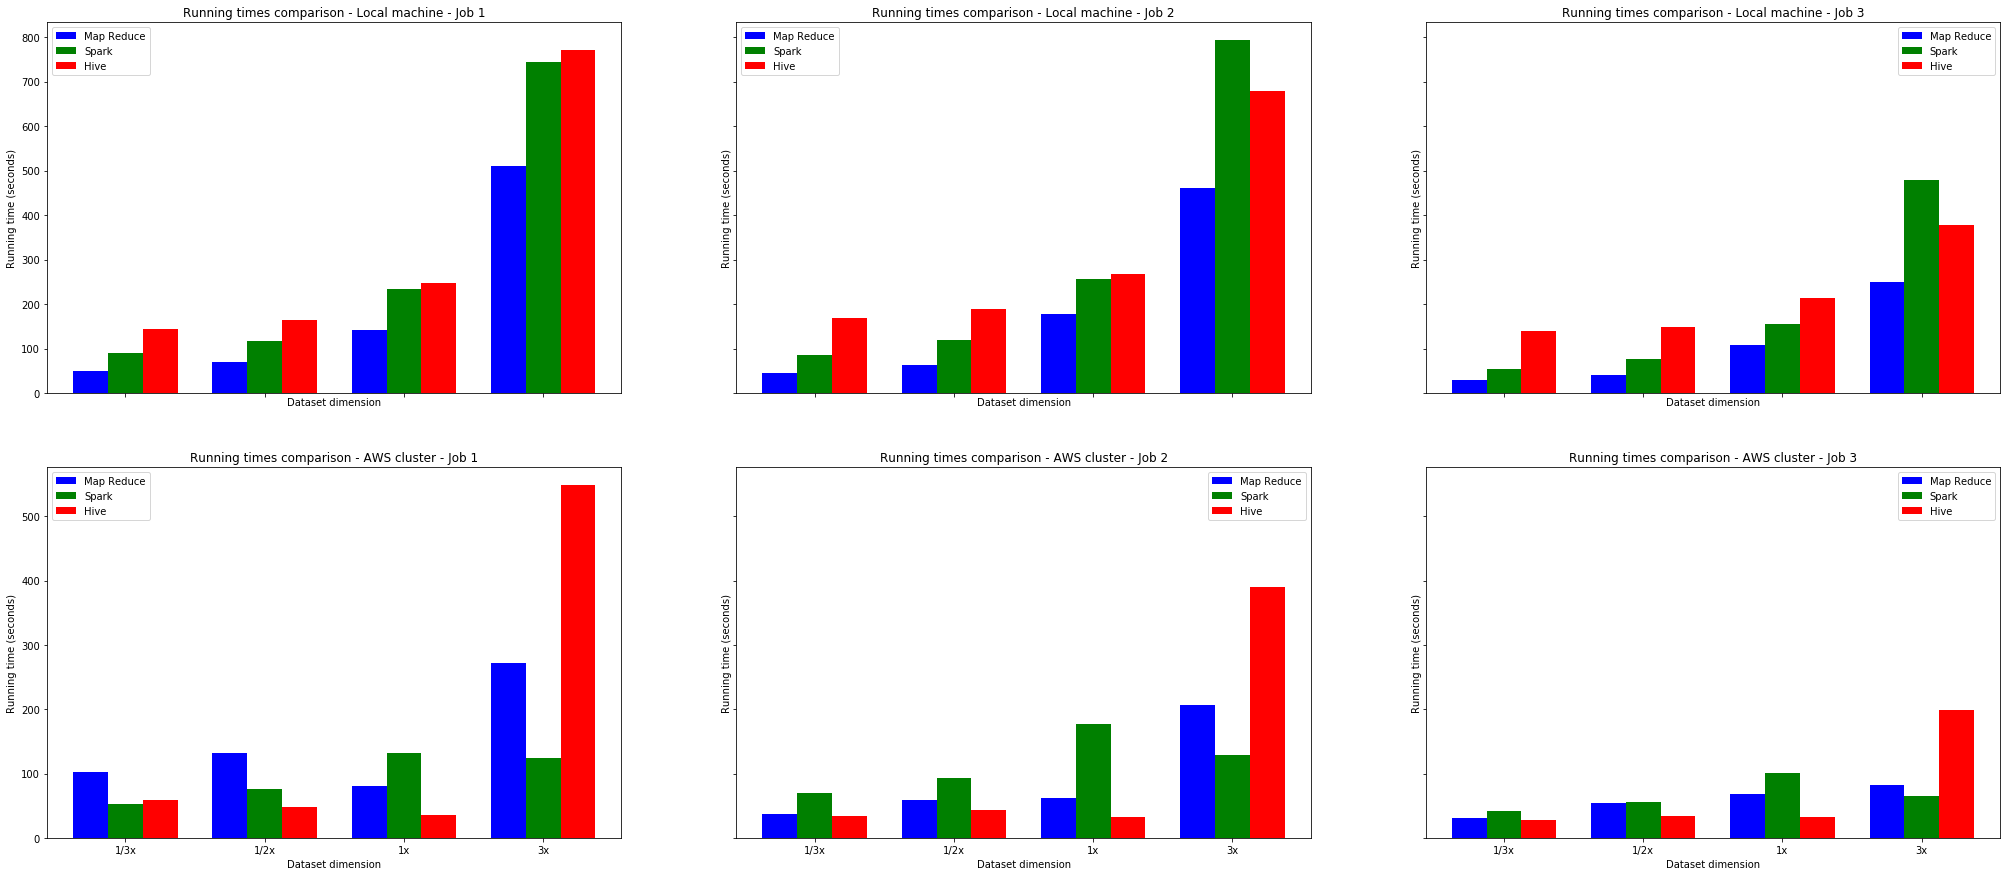

In [13]:
def running_time_comparison(machines, jobs, map_reduce_jobs_times, spark_jobs_times, hive_jobs_times):
    '''
   Create 6 charts (3 per row).
   The first row is for jobs running times on local machine.
   The second row is for jobs running times on AWS cluster.
   '''
    rows, cols = 2, 3
 
    fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(35, 15))
 
    for row in range(2):
        for col in range(3):
            ax[row][col].bar(X + 0.00, map_reduce_jobs_times[row][col], color = 'blue', width = 0.25, align='center')
            ax[row][col].bar(X + 0.25, spark_jobs_times[row][col], color = 'green', width = 0.25, align='center')
            ax[row][col].bar(X + 0.50, hive_jobs_times[row][col], color = 'red', width = 0.25, align='center')
 
            ax[row][col].legend(['Map Reduce', 'Spark', 'Hive'])
            ax[row][col].set_xlabel('Dataset dimension')
            ax[row][col].set_ylabel('Running time (seconds)')
            ax[row][col].set_title('Running times comparison - {} - {}'.format(machines[row], jobs[col]))
            ax[row][col].set_xticks(np.arange(4)+0.25)
            ax[row][col].set_xticklabels(('1/3x', '1/2x', '1x', '3x'), fontdict=None, minor=False)
 
    plt.show()
    fig.savefig('big_data_jobs_running_time_comparison.png', bbox_inches='tight')
 
running_time_comparison(machines, jobs, map_reduce_jobs_times, spark_jobs_times, hive_jobs_times)

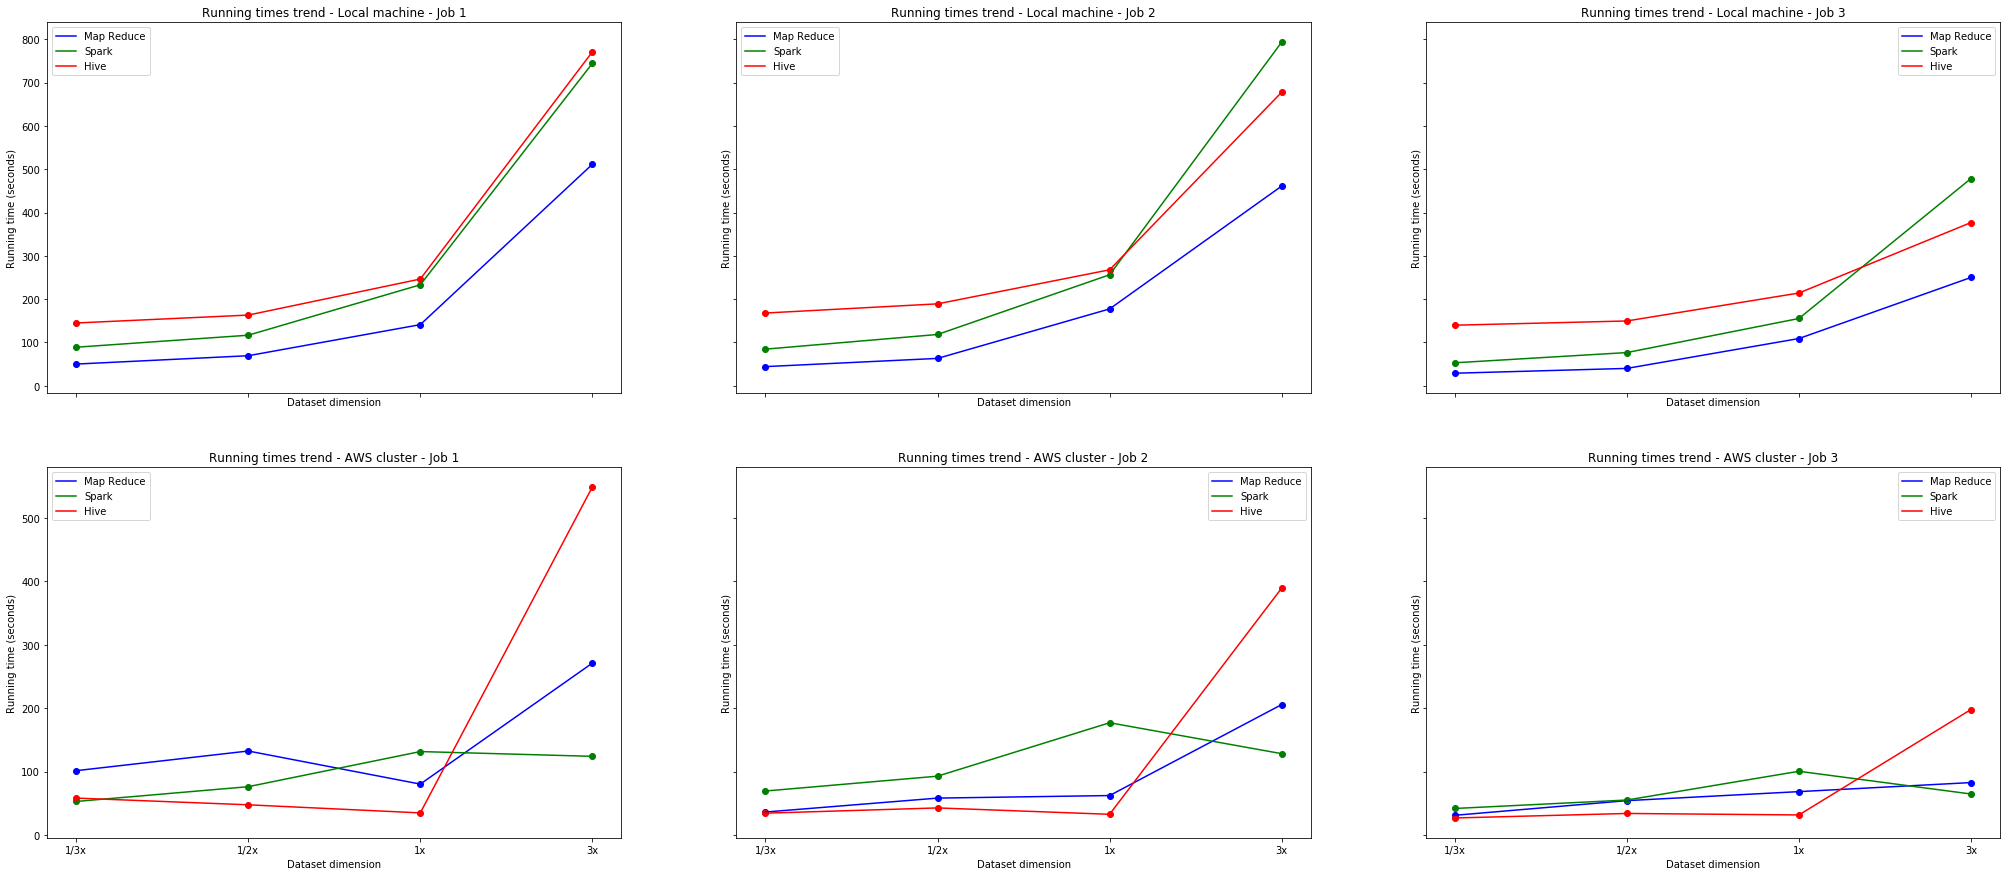

In [14]:
def running_time_trends(machines, jobs, map_reduce_jobs_times, spark_jobs_times, hive_jobs_times):
    '''
   Create 6 charts (3 per row).
   The first row is for jobs running times trend on local machine.
   The second row is for jobs running times trend on AWS cluster.
   '''
    rows, cols = 2, 3
 
    fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(35, 15))
     
    for row in range(2):
        for col in range(3):
            ax[row][col].plot(X, map_reduce_jobs_times[row][col], color = 'blue')
            ax[row][col].scatter(X, map_reduce_jobs_times[row][col], color = 'blue')
            ax[row][col].plot(X, spark_jobs_times[row][col], color = 'green')
            ax[row][col].scatter(X, spark_jobs_times[row][col], color = 'green')
            ax[row][col].plot(X, hive_jobs_times[row][col], color = 'red')
            ax[row][col].scatter(X, hive_jobs_times[row][col], color = 'red')
           
           
            ax[row][col].legend(['Map Reduce', 'Spark', 'Hive'])
            ax[row][col].set_xlabel('Dataset dimension')
            ax[row][col].set_ylabel('Running time (seconds)')
            ax[row][col].set_title('Running times trend - {} - {}'.format(machines[row], jobs[col]))
            ax[row][col].set_xticks(np.arange(4))
            ax[row][col].set_xticklabels(('1/3x', '1/2x', '1x', '3x'), fontdict=None, minor=False)
 
    plt.show()
    fig.savefig('big_data_jobs_running_time_trends.png', bbox_inches='tight')
 
running_time_trends(machines, jobs, map_reduce_jobs_times, spark_jobs_times, hive_jobs_times)

# 6. Conclusions

### Job 1

We can note that locally the execution times of the Hive and Spark paradigms are comparable, while there is a reduction in the execution time of the Map Reduce paradigm.
It can also be noted that as the size of the dataset grows, all three paradigms assume an exponential behavior, in particular there is a significant increase in the execution time when the dataset has been tripled.

As far as cluster execution is concerned, we can see how the execution time of the Hive paradigm by far detaches the execution times of Spark and Map Reduce, especially in the presence of the tripled dataset.
Instead, Spark's run time is kept constant even when the dataset is tripled, making it the most efficient paradigm.

### Job 2

We can note that both in local and on clusters, the behavior of the three paradigms is very similar to the progress of job 1, with the difference, however, that on clusters we have a reduction in execution times.

### Job 3

Here too, as in job 2, both locally and on clusters, we can notice a similarity of the curves with the previous ones, with the difference that there is a clear reduction in the execution times (about half).